In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
import os
from varname import nameof
import matplotlib.pyplot as plt
import seaborn as sns

In [9]:
def plot_acc(history, num_classes, experiment):
    plt.plot(history.history['accuracy'], color='darkgreen')
    plt.plot(history.history['val_accuracy'], color='salmon')
    plt.title('{}-{} model accuracy'.format(num_classes, experiment))
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('./plots/model_acc_{}{}s.png'.format(num_classes, experiment))
    plt.close()

def plot_loss(history, num_classes, experiment):
    plt.plot(history.history['loss'], color='darkgreen')
    plt.plot(history.history['val_loss'], color='salmon')
    plt.title('{}-{} model loss'.format(num_classes, experiment))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('./plots/model_loss_{}{}s.png'.format(num_classes, experiment))
    plt.close()

def plot_cm(confusion_matrix, classes, num_classes, experiment):
    plt.figure(figsize=(8,6))
    sns.heatmap(confusion_matrix, xticklabels=classes, yticklabels=classes, annot=True, cmap='BuGn')
    plt.title('{}-{} model confusion matrix'.format(num_classes, experiment))
    plt.xlabel('Pred')
    plt.ylabel('True')
    plt.show()
    plt.savefig('./plots/model_cm_{}{}s.png'.format(num_classes, experiment))

In [10]:
label_to_playlists = {
    'jazz_playlists'      : 1,
    'classical_playlists' : 2,
    'indie_playlists'     : 3,
    'country_playlists'   : 4,
    'rock_playlists'      : 5,
    # 'pop_playlists'       : 6,
    'hip_hop_playlists'   : 7,
    'edm_playlists'       : 8
}
num_classes = len(label_to_playlists.keys())
label = 0
all_features_df = None
all_labels_df = None

for name, original_label in label_to_playlists.items():
    playlists_df = None
    path = os.path.join(os.getcwd(), "data", f"{name}_label_{original_label}.csv")
    dataframe = pd.read_csv(path)
    dataframe = dataframe.drop_duplicates(subset='track_id', keep=False)
    labels = dataframe.pop('label')
    labels = labels.astype('float32')
    labels.values[:] = label
    features = dataframe.drop(['Unnamed: 0', 'track_id'], axis=1)
    features.astype('float32') 
    if all_features_df is None:
        all_features_df = features
    else:
        all_features_df = pd.concat(
                [all_features_df, features],
                axis=0,
                join="outer",
                ignore_index=False,
                keys=None,
                levels=None,
                names=None,
                verify_integrity=False,
                copy=True,
            )
    if all_labels_df is None:
        all_labels_df = labels
    else:
        all_labels_df = pd.concat(
                [all_labels_df, labels],
                axis=0,
                join="outer",
                ignore_index=False,
                keys=None,
                levels=None,
                names=None,
                verify_integrity=False,
                copy=True,
            )
    label+=1

Epoch 1/100
42/42 [==============================] - 2s 14ms/step - loss: 2.3297 - accuracy: 0.1447 - val_loss: 1.9616 - val_accuracy: 0.2108
Epoch 2/100
42/42 [==============================] - 0s 4ms/step - loss: 2.0628 - accuracy: 0.1515 - val_loss: 1.8873 - val_accuracy: 0.2289
Epoch 3/100
42/42 [==============================] - 0s 4ms/step - loss: 1.9593 - accuracy: 0.1816 - val_loss: 1.8609 - val_accuracy: 0.2681
Epoch 4/100
42/42 [==============================] - 0s 4ms/step - loss: 1.9003 - accuracy: 0.2344 - val_loss: 1.8377 - val_accuracy: 0.2771
Epoch 5/100
42/42 [==============================] - 0s 4ms/step - loss: 1.8690 - accuracy: 0.2532 - val_loss: 1.8145 - val_accuracy: 0.2982
Epoch 6/100
42/42 [==============================] - 0s 4ms/step - loss: 1.8375 - accuracy: 0.2457 - val_loss: 1.7903 - val_accuracy: 0.2982
Epoch 7/100
42/42 [==============================] - 0s 5ms/step - loss: 1.8148 - accuracy: 0.2705 - val_loss: 1.7677 - val_accuracy: 0.2892
Epoch 8/100


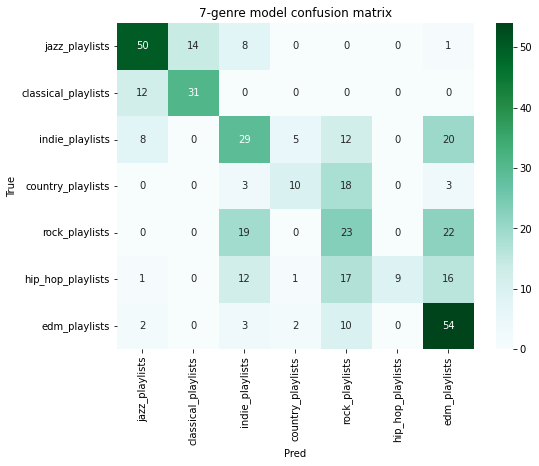

<Figure size 432x288 with 0 Axes>

In [11]:

x_train, x_test, y_train, y_test = train_test_split(all_features_df, all_labels_df, test_size=0.20)

# leaky_relu = keras.layers.LeakyReLU(alpha=0.1)
leaky_relu = keras.layers.ReLU()

model = keras.models.Sequential([
    keras.Input(shape=(11,)),
    keras.layers.Dense(128, activation=leaky_relu),
    keras.layers.Dense(64, activation=leaky_relu),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation=leaky_relu),
    keras.layers.Dense(32, activation=leaky_relu),
    keras.layers.LayerNormalization(),
    keras.layers.Dense(num_classes),
    keras.layers.Softmax()
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer, loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

history = model.fit(x_train, y_train, batch_size=32, epochs=100, validation_split=0.2)

print(model.evaluate(
    x=x_test,
    y=y_test,
))

preds = model.predict(x_test)
preds = tf.argmax(preds, axis=-1)
confusion_matrix = tf.math.confusion_matrix(y_test, preds, num_classes=num_classes)

plot_cm(confusion_matrix, label_to_playlists.keys(), num_classes, "genre")
